<a href="https://colab.research.google.com/github/danzerca/aim4/blob/main/Prototyping_LangChain_Application_with_Production_Minded_Changes_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [2]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 2

We'll need an OpenAI API Key:

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [4]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [5]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - f5be5c45


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [6]:
from google.colab import files
uploaded = files.upload()

Saving The-pmarca-Blog-Archives.pdf to The-pmarca-Blog-Archives.pdf


In [7]:
file_path = list(uploaded.keys())[0]
file_path

'The-pmarca-Blog-Archives.pdf'

We'll define our chunking strategy.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [10]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

--> Limitations of cache-backed embeddings:

- Storage requirements: Caching embeddings can consume significant storage space, especially for large datasets or high-dimensional embeddings.

- Cold start problem: Initial queries or new data will still require full embedding computation, potentially causing latency spikes.

- Model updates: If the embedding model is updated, all cached embeddings may need to be recomputed, which can be time-consuming and resource-intensive.


--> When cache-backed embeddings are most useful:

- Frequent repeated queries: When the same or similar text inputs are processed multiple times.

- Large-scale applications: In systems dealing with massive amounts of data where recomputing embeddings would be prohibitively expensive.

- Low-latency requirements: For applications where quick response times are critical, such as real-time recommendation systems.

--> When cache-backed embeddings are least useful:

- Rapidly changing data: In scenarios where the underlying text data changes frequently, requiring constant cache updates.

- Unique or rarely repeated inputs: When most inputs are unique and unlikely to be reused, reducing the benefits of caching.

- Small-scale applications: For smaller datasets or applications where the overhead of managing a cache might outweigh the benefits.


##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [11]:
### YOUR CODE HERE
import time

# Function to time embedding process
def time_embedding(text, embedder):
    start_time = time.time()
    embedding = embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

# Test text
test_text = "This is a test sentence to embed."

# First run - should take longer as it's not cached
print("First run (not cached):")
time_taken = time_embedding(test_text, cached_embedder)
print(f"Time taken: {time_taken:.4f} seconds")

# Second run - should be faster due to caching
print("\nSecond run (should be cached):")
time_taken = time_embedding(test_text, cached_embedder)
print(f"Time taken: {time_taken:.4f} seconds")

# Third run with different text - should take longer again
print("\nThird run (different text, not cached):")
time_taken = time_embedding("This is a completely different sentence.", cached_embedder)
print(f"Time taken: {time_taken:.4f} seconds")

# Fourth run - back to original text, should be fast
print("\nFourth run (back to original text, should be cached):")
time_taken = time_embedding(test_text, cached_embedder)
print(f"Time taken: {time_taken:.4f} seconds")


First run (not cached):
Time taken: 0.4007 seconds

Second run (should be cached):
Time taken: 0.3316 seconds

Third run (different text, not cached):
Time taken: 0.2490 seconds

Fourth run (back to original text, should be cached):
Time taken: 0.2861 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [13]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [14]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

--> Limitations of prompt caching:

- Staleness of data: Cached responses may become outdated, especially for queries about current events or rapidly changing information.

- Context sensitivity: Slight changes in context or phrasing might lead to different optimal responses, but the cache would return the same result.

- Lack of creativity: For tasks requiring unique or creative outputs each time, caching may be counterproductive.

--> When prompt caching is most useful:

- Frequently asked questions: For common queries that have stable answers over time.

- API cost reduction: To minimize API calls for paid services like OpenAI.

- Offline or limited connectivity scenarios: Caching can provide responses when network access is limited.

--> When prompt caching is least useful:

- Real-time data needs: For queries requiring up-to-the-minute information.

- Highly personalized interactions: When each response should be tailored to the user's specific context.

- Learning or adaptive systems: Where the AI should be continuously improving or adapting its responses.


##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [15]:
### YOUR CODE HERE

from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

# Function to time the model response
def time_model_response(question):
    start_time = time.time()
    response = retrieval_augmented_qa_chain.invoke({"question": question})
    end_time = time.time()
    return end_time - start_time, response.content[:100]  # Return time and first 100 chars of response

# Test question
test_question = "What is the main topic of this document?"

# First run - should take longer as it's not cached
print("First run (not cached):")
time_taken, response = time_model_response(test_question)
print(f"Time taken: {time_taken:.4f} seconds")
print(f"Response preview: {response}")

# Second run - should be faster due to caching
print("\nSecond run (should be cached):")
time_taken, response = time_model_response(test_question)
print(f"Time taken: {time_taken:.4f} seconds")
print(f"Response preview: {response}")

# Third run with different question - should take longer again
print("\nThird run (different question, not cached):")
time_taken, response = time_model_response("What are the key points discussed in the document?")
print(f"Time taken: {time_taken:.4f} seconds")
print(f"Response preview: {response}")

# Fourth run - back to original question, should be fast
print("\nFourth run (back to original question, should be cached):")
time_taken, response = time_model_response(test_question)
print(f"Time taken: {time_taken:.4f} seconds")
print(f"Response preview: {response}")


First run (not cached):
Time taken: 2.0710 seconds
Response preview: The main topic of the document appears to be the exploration of the relationship between age and exc

Second run (should be cached):
Time taken: 0.5556 seconds
Response preview: The main topic of the document appears to be the exploration of the relationship between age and exc

Third run (different question, not cached):
Time taken: 5.7031 seconds
Response preview: The document discusses several key points related to organizational design, creativity, and producti

Fourth run (back to original question, should be cached):
Time taken: 0.4039 seconds
Response preview: The main topic of the document appears to be the exploration of the relationship between age and exc


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [16]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [18]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "The Pmarca Blog Archives."\n2. It is formatted as a PDF (version 1.3).\n3. The document has a total of 195 pages.\n4. The specific page referenced is page 134.\n5. The document was created on January 10, 2015.\n6. It was last modified on the same date, January 10, 2015.\n7. The document was produced using Mac OS X 10.10 Quartz PDFContext.\n8. The source of the document is listed as "source_271."\n9. The document does not specify an author.\n10. There are no keywords mentioned in the metadata.\n11. The document includes a section on productivity techniques.\n12. A notable technique discussed involves using a 3x5 card for daily tasks.\n13. The author mentions keeping tasks in Microsoft Word\'s outline mode.\n14. The technique recommends selecting 3 to 5 significant tasks for the day.\n15. The 3x5 card is used to write down tasks before going to bed.\n16. The next day, the focus is on completing those tasks.\n17. It is described as one of the 

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

--> Below you can see the result of leveraging cache-backed embeddings and LLM calls. The original call of "Write 50 things about this document!" had a latency of 10.49s. Making the call a second time shows a latency of only 0.57s. This is a huge improvement for a repeat question! The call to ChatOpenAI is nearly 0s in the second call because the information is stored in the cache.

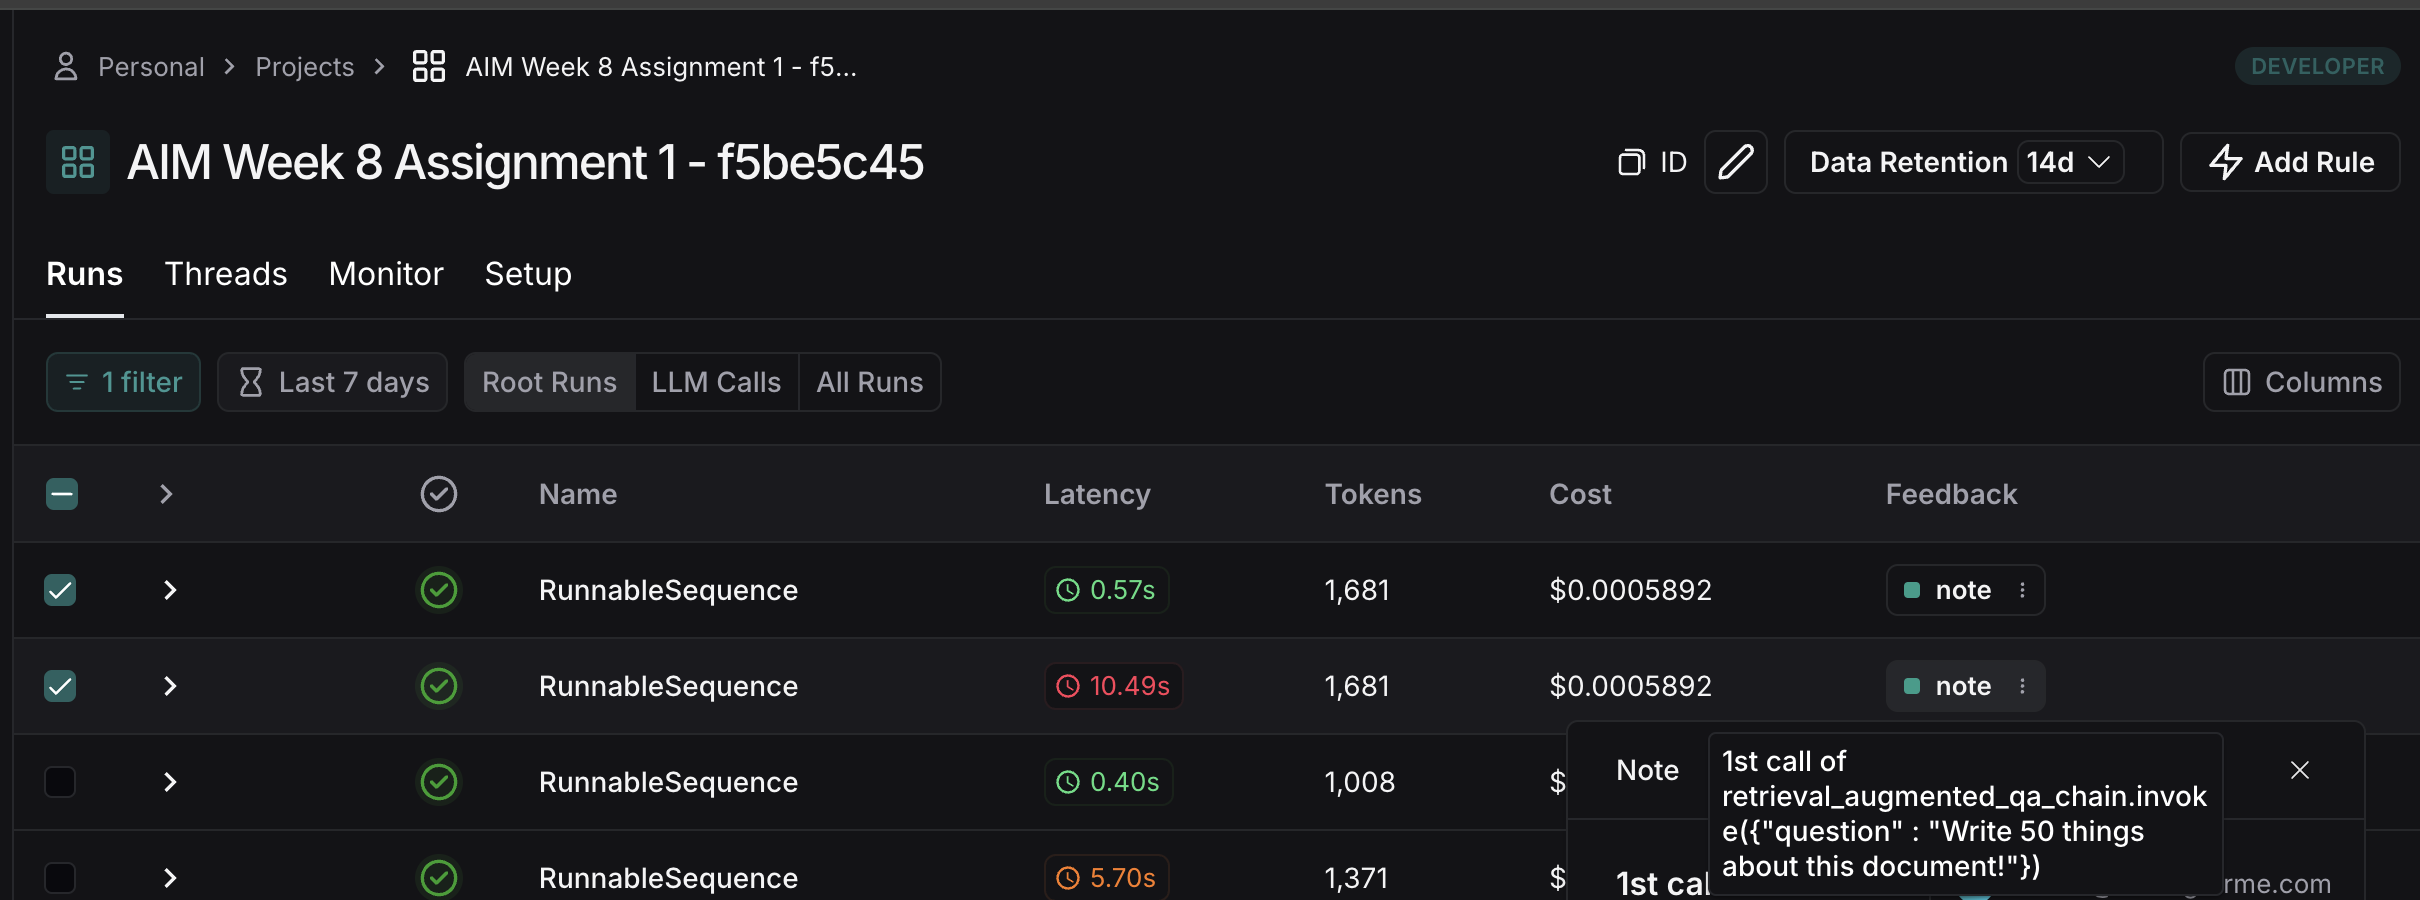

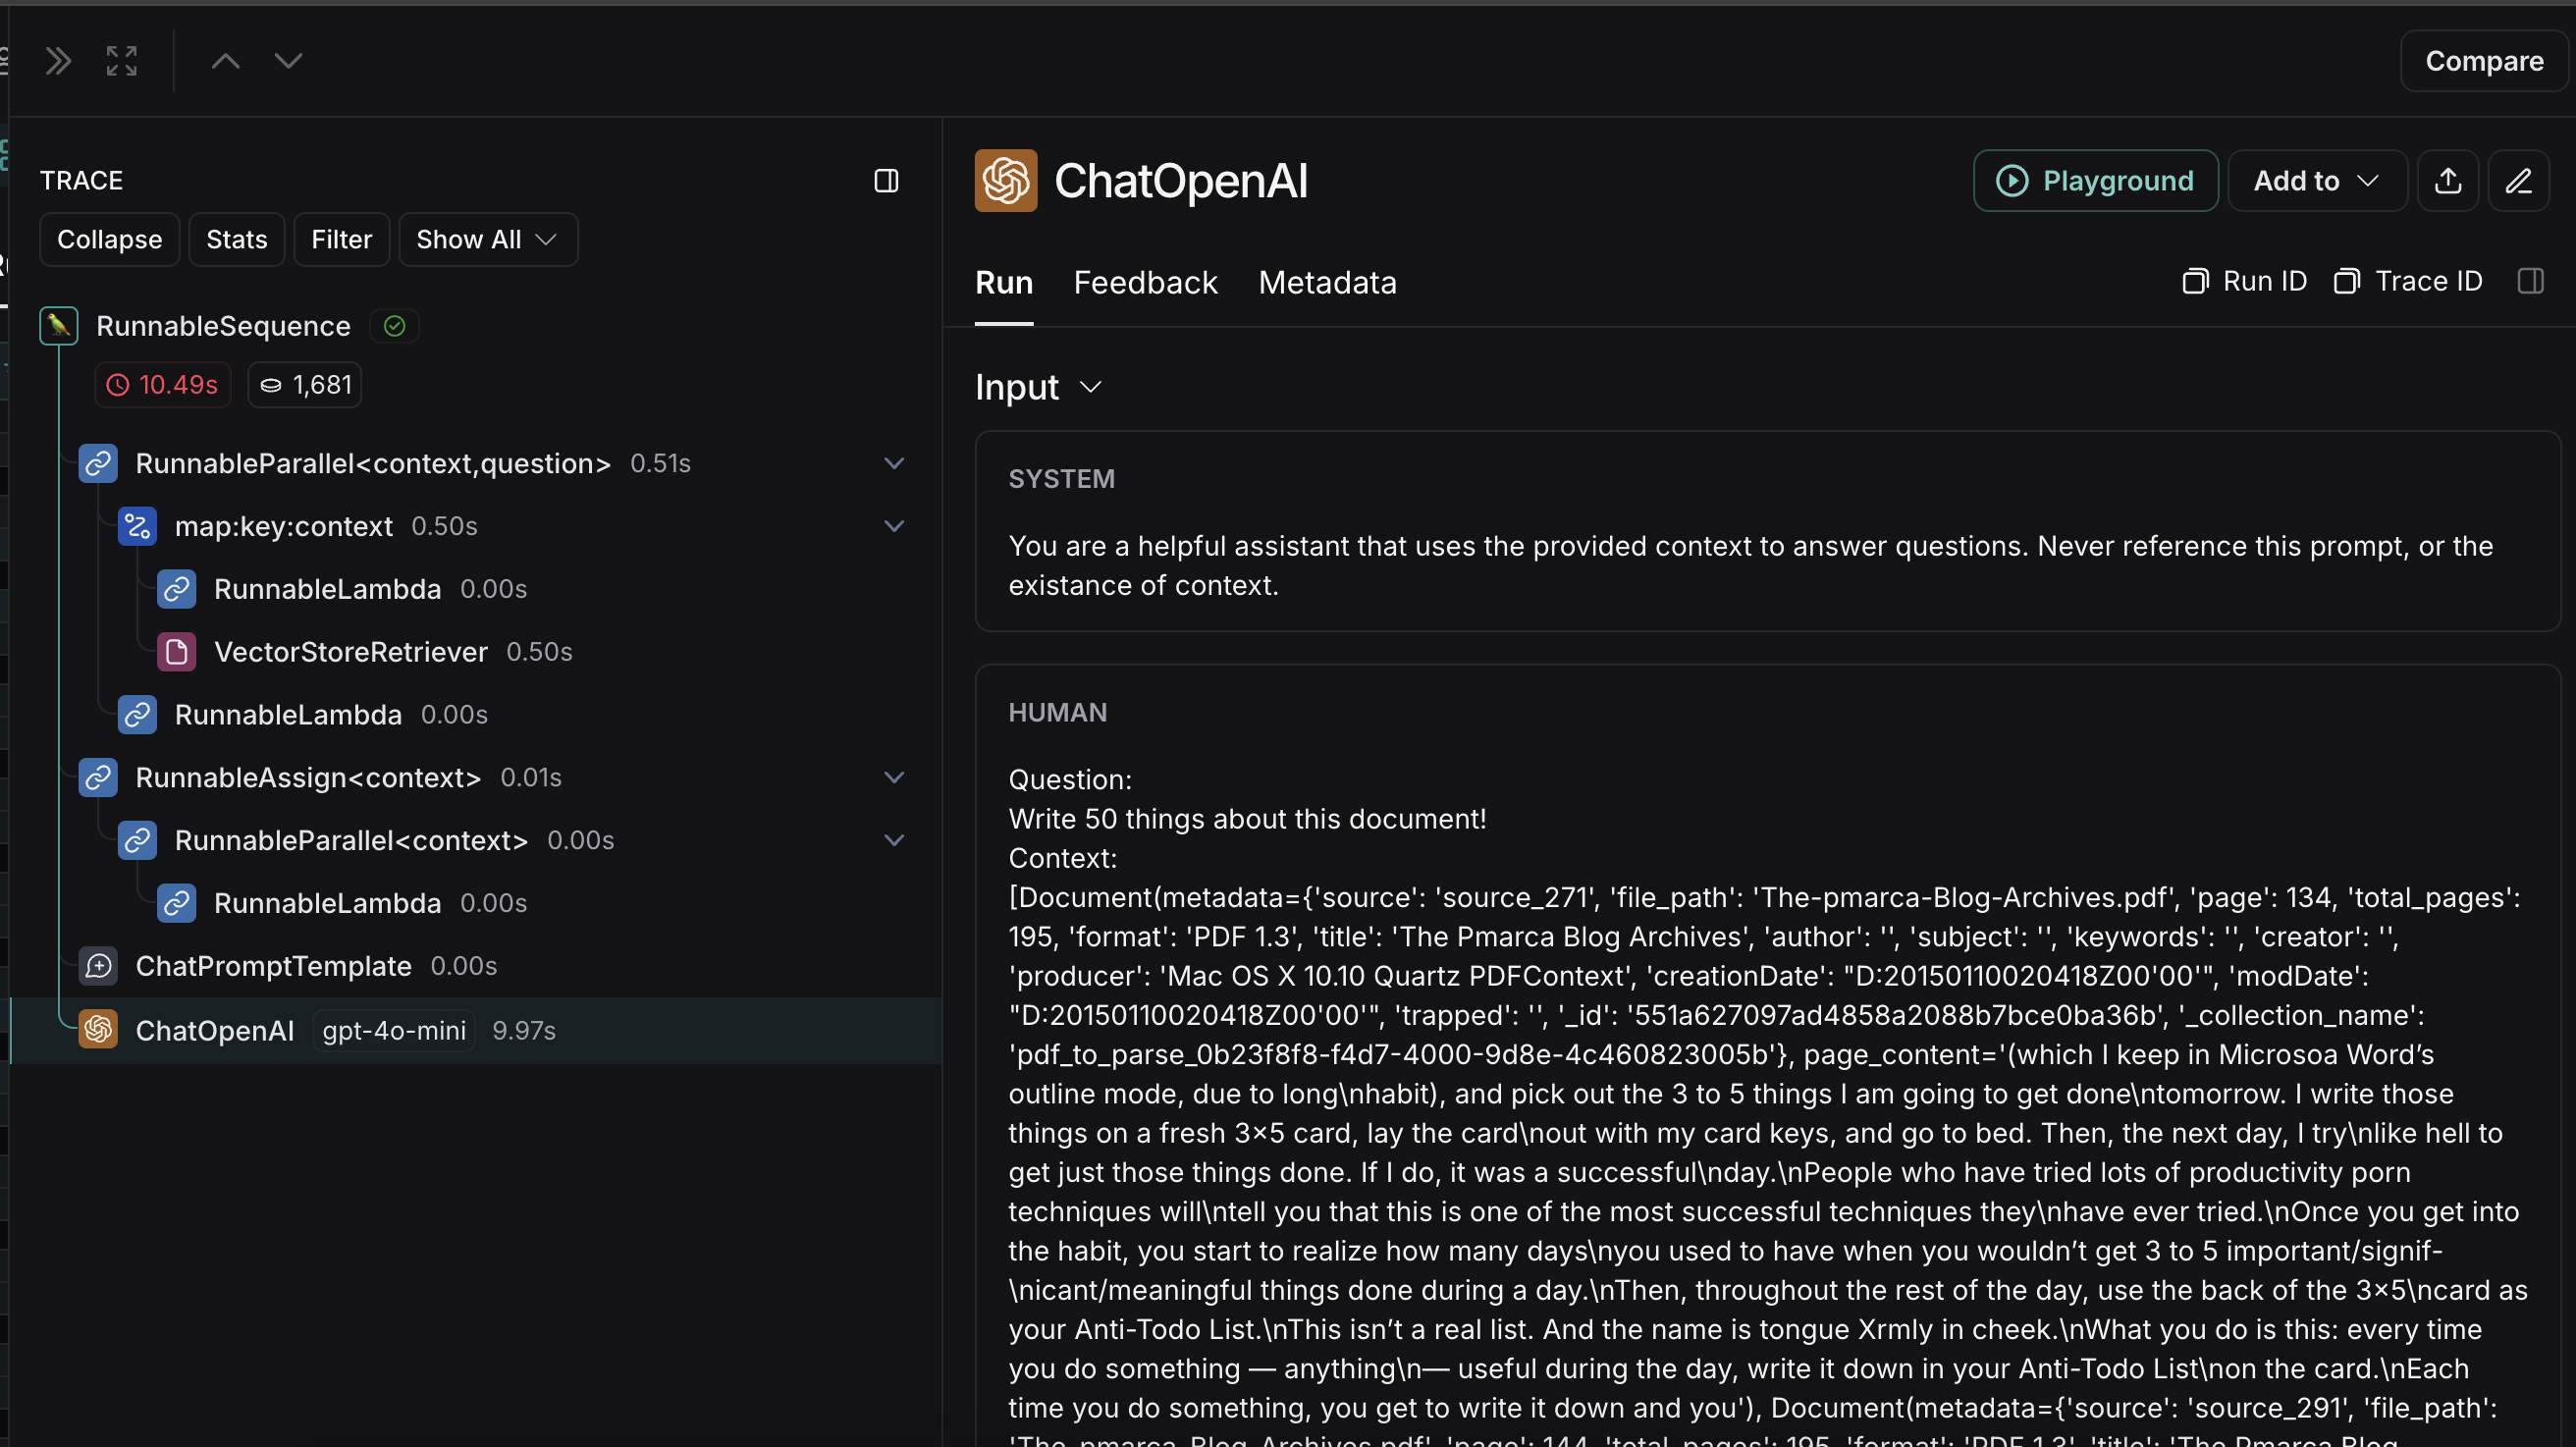

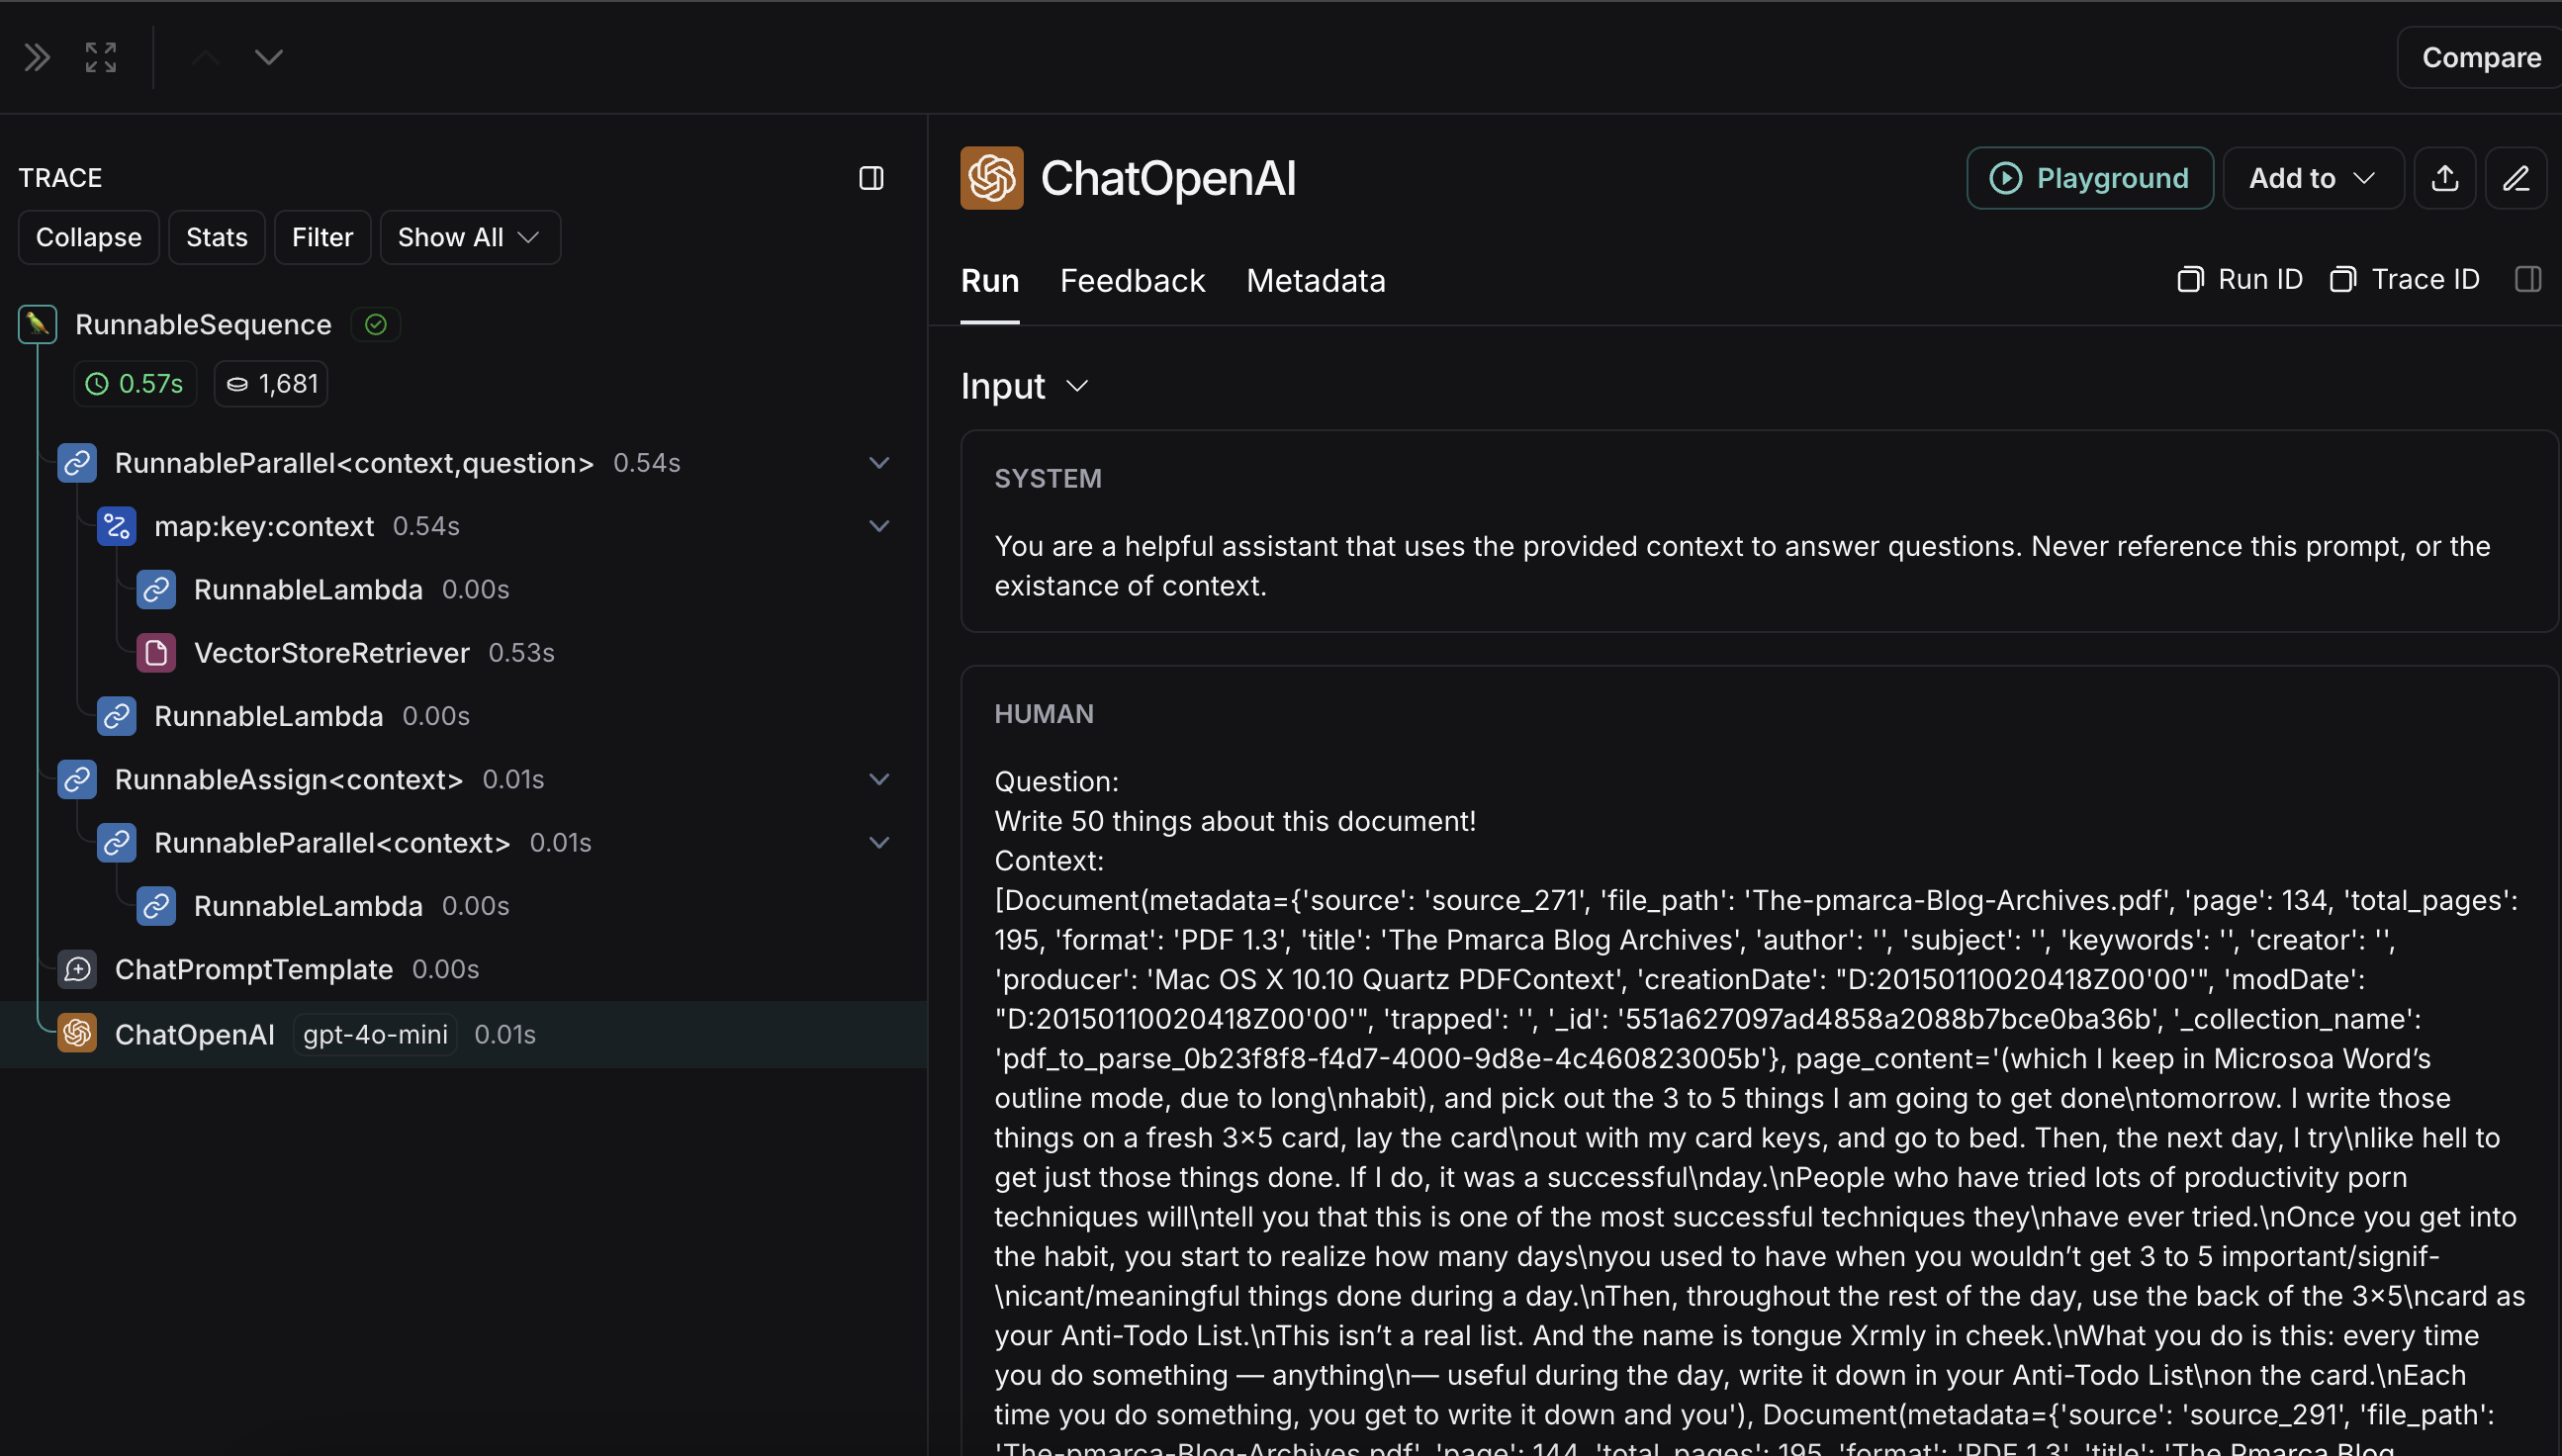